# Latent space analyses dummy beta-VAE

In [94]:
import os
import glob
import sys

p = os.path.abspath('../')
if p not in sys.path:
    sys.path.append(p)
    
q = os.path.abspath('../../')
if q not in sys.path:
    sys.path.append(q)

import moving_averages as ma
import colorado as cld
import dico_toolbox as dtx
from tqdm import tqdm

import pandas as pd
import numpy as np
from scipy.spatial import distance

import plotly.graph_objects as go
import pickle
import matplotlib.pyplot as plt

from soma import aims

from preprocess import SkeletonDataset
from load_data import create_subset
import torch
from vae import *

from sklearn.cluster import KMeans, SpectralClustering, AffinityPropagation
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM

import matplotlib.cm as cm

from config import Config

In [3]:
path = '/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/Rcrops/'

In [4]:
if torch.cuda.is_available():
    device = "cuda:0"

##### Model

In [5]:
model_dir = '/neurospin/dico/lguillon/miccai_22/vae/n_4_w_2/checkpoint.pt'
model = VAE((1, 40, 40, 56), 4, depth=3)
model.load_state_dict(torch.load(model_dir))
model = model.to(device)

### Loading of subjects' distribution in the latent space

##### HCP test set

In [72]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

test_list = pd.read_csv(os.path.join(subject_dir, "test_list.csv"))

test_list['subjects'] = test_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')
tmp = tmp.rename(columns={0: "skeleton"})

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')

filenames_hcp = list(test_list['subjects'])

subset = SkeletonDataset(dataframe=tmp, filenames=filenames,
                        visu_check=False)

dataloader = torch.utils.data.DataLoader(
              subset,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

##### SC int
[111009, 138231, 510225, 199251, 159946, 140319, 212419] 

In [7]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

scint_list = ['111009', '138231', '510225', '199251', '159946', '140319', '212419']
scint_df = pd.DataFrame(scint_list, columns=['subjects'])

tmp_int = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
tmp_int = tmp_int.rename(columns={0:'skeleton'})
tmp_int.index.astype('str')

tmp_int = tmp_int.merge(scint_df, left_on = tmp_int.index, right_on='subjects', how='right')

filenames = scint_list

subset = SkeletonDataset(dataframe=tmp_int, filenames=filenames, visu_check=False)

dataloader_int = torch.utils.data.DataLoader(
              subset,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

##### OH

In [8]:
labels = pd.read_csv('/neurospin/dico/lguillon/ohbm_22/one_handed_labels.csv')
labels

,SubjID,Gender,Age at time of scan,Age at limb loss,Group,Amp. Side,Dominant hand
0,PA01,M,57,20.0,AMP,L,NaN
1,PA02,F,49,0.0,CONG,L,NaN
2,PA03,M,59,40.0,AMP,L,NaN
3,PA04,F,52,0.0,CONG,R,NaN
4,PA05,M,58,27.0,AMP,L,NaN
5,PA06,M,53,28.0,AMP,L,NaN
6,PA07,M,52,0.0,CONG,L,NaN
7,PA08,M,41,27.0,AMP,R,NaN
8,PA09,M,48,17.0,AMP,L,NaN
9,PA10,F,25,0.0,CONG,R,NaN


In [9]:
ctrl = labels[labels['Dominant hand']=='R']
one_handed = labels[labels['Group']!='CTR']
one_handed = labels[labels['Amp. Side']=='L']

amputee = one_handed[one_handed['Group']=='AMP']
cong = one_handed[one_handed['Group']=='CONG']

In [ ]:
len(ctrl)

In [27]:
# One-handed dataset

data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/one_handed_dataset/"

tmp3 = pd.read_pickle(data_dir+'R_one_handed_skeleton.pkl')
tmp3 = tmp3.T
tmp3 = tmp3.rename(columns={0:'skeleton'})
tmp3['subjects'] = [list(tmp3.index)[k][0:4] for k in range(len(tmp3))]

controls = tmp3.merge(ctrl, left_on=tmp3.subjects, right_on='SubjID', how='inner')
filenames = list(controls.SubjID)
control_dataset = SkeletonDataset(dataframe=controls, filenames=filenames, visu_check=False)
control_loader = torch.utils.data.DataLoader(control_dataset, batch_size=1,
                                                    shuffle=True, num_workers=8)

amputee = tmp3.merge(amputee, left_on=tmp3.subjects, right_on='SubjID', how='inner')
filenames_amp = list(amputee.SubjID)
amputee_dataset = SkeletonDataset(dataframe=amputee, filenames=filenames_amp,visu_check=False)
amputee_loader = torch.utils.data.DataLoader(amputee_dataset, batch_size=1,
                                                    shuffle=True, num_workers=8)

congenital = tmp3.merge(cong, left_on=tmp3.subjects, right_on='SubjID', how='inner')
filenames_cong = list(cong.SubjID)
congenital_dataset = SkeletonDataset(dataframe=congenital, filenames=filenames_cong, visu_check=False)
congenital_loader = torch.utils.data.DataLoader(congenital_dataset, batch_size=1,
                                                    shuffle=True, num_workers=8)

dico_set_loaders = {'ctrl': control_loader, 'amputee': amputee_loader, 'congenital': congenital_loader}

In [28]:
print(len(controls), len(amputee), len(congenital))

16 12 12


In [29]:
amputee.head()

,skeleton,subjects,skeleton_x,subjects_x,skeleton_y,subjects_y,SubjID,Gender,Age at time of scan,Age at limb loss,Group,Amp. Side,Dominant hand
0,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA19,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA19,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA19,PA19,M,49,37.0,AMP,L,NaN
1,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA09,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA09,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA09,PA09,M,48,17.0,AMP,L,NaN
2,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA13,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA13,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA13,PA13,F,46,38.0,AMP,L,NaN
3,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA25,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA25,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA25,PA25,M,29,24.0,AMP,L,NaN
4,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA29,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA29,"[[[[0], [0], [0], [0], [0], [0], [0], [0], [0]...",PA29,PA29,M,25,18.0,AMP,L,NaN


In [30]:
dico_set_loaders = {'hcp': dataloader, 'scint': dataloader_int, 'ctrl': control_loader, 'amputee': amputee_loader, 'congenital': congenital_loader}

root_dir = '/neurospin/dico/lguillon/miccai_22/vae/n_4_w_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3)

In [31]:
results = tester.test()
encoded = {loader_name:[results[loader_name][k][1] for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}
losses = {loader_name:[int(results[loader_name][k][0].cpu().detach().numpy()) for k in results[loader_name].keys()] for loader_name in dico_set_loaders.keys()}

df_encoded = pd.DataFrame()
df_encoded['latent'] = encoded['hcp'] + encoded['scint'] + encoded['ctrl'] + encoded['amputee'] + encoded['congenital']
df_encoded['Group'] = ['hcp' for k in range(len(tmp))] + ['scint' for k in range(len(tmp_int))]+ ['ctrl' for k in range(len(controls))] + ['amputee' for k in range(len(amputee))] +['congenital'for k in range(len(congenital))]

X = np.array(list(df_encoded['latent']))
labels = np.array(df_encoded['Group'])

tensor(4176.2290, device='cuda:0')
tensor(3706.2024, device='cuda:0')
tensor(3605.2358, device='cuda:0')
tensor(3857.4695, device='cuda:0')
tensor(3871.7505, device='cuda:0')
tensor(3581.1804, device='cuda:0')
tensor(4103.1587, device='cuda:0')
tensor(4082.5503, device='cuda:0')
tensor(4072.7300, device='cuda:0')
tensor(4254.4746, device='cuda:0')
tensor(3761.2439, device='cuda:0')
tensor(4241.1445, device='cuda:0')
tensor(3617.0605, device='cuda:0')
tensor(4199.6504, device='cuda:0')
tensor(3679.1096, device='cuda:0')
tensor(4285.9844, device='cuda:0')
tensor(4290.2812, device='cuda:0')
tensor(4333.1069, device='cuda:0')
tensor(4041.1394, device='cuda:0')
tensor(3688.1218, device='cuda:0')
tensor(3819.3494, device='cuda:0')
tensor(3573.5996, device='cuda:0')
tensor(3858.6799, device='cuda:0')
tensor(4447.3105, device='cuda:0')
tensor(3778.5703, device='cuda:0')
tensor(3811.9497, device='cuda:0')
tensor(3606.2278, device='cuda:0')
tensor(4431.8408, device='cuda:0')
tensor(3639.3657, de

tensor(3369.0840, device='cuda:0')
tensor(3564.2251, device='cuda:0')
tensor(3240.6489, device='cuda:0')
tensor(3746.5210, device='cuda:0')
tensor(3378.4675, device='cuda:0')
tensor(3461.6665, device='cuda:0')
tensor(3223.3181, device='cuda:0')
tensor(3462.5190, device='cuda:0')
tensor(3838.7219, device='cuda:0')
tensor(3806.1797, device='cuda:0')
tensor(3819.9729, device='cuda:0')
tensor(4023.9541, device='cuda:0')


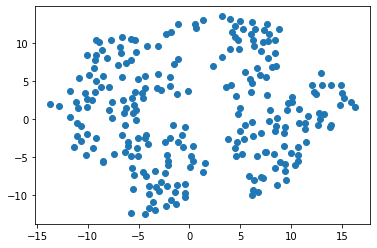

In [32]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=12).fit_transform(X)

x = [X_embedded[k][0] for k in range(len(X_embedded))]
y = [X_embedded[k][1] for k in range(len(X_embedded))]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(x, y)

In [33]:
subjects_name = ['' for k in range(200)] + scint_list + ['' for k in range(len(controls))] + filenames_amp + filenames_cong

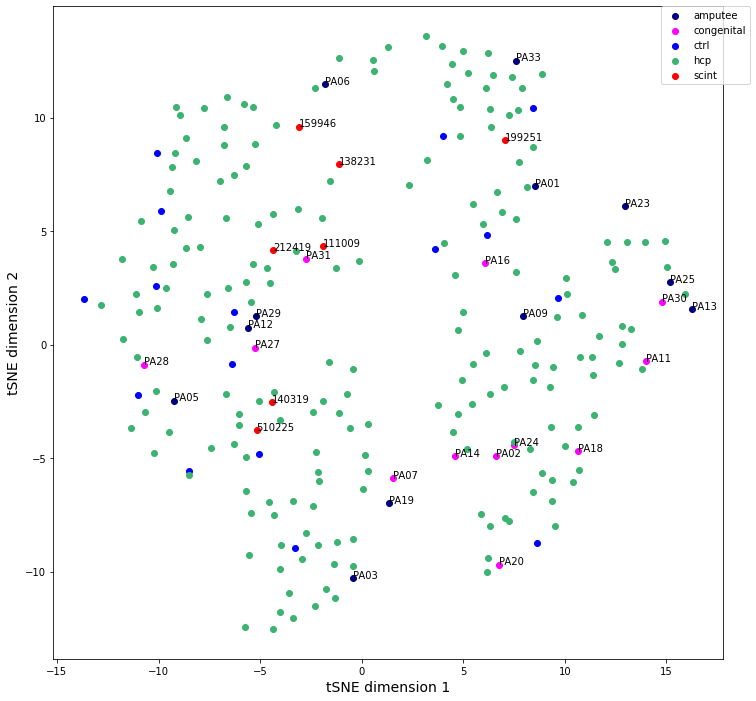

In [34]:
arr = X_embedded
color_dict = {'hcp':'mediumseagreen', 'scint': 'red', 'ctrl': 'blue', 'congenital':'magenta', 'amputee': 'navy'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(labels):
    ix = np.where(labels == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [74]:
encoded['congenital']

[array([ 1.8889456 ,  0.12120526,  1.9804226 , -1.5426834 ], dtype=float32),
 array([ 3.3123512 ,  0.33383277,  1.6183677 , -0.6011713 ], dtype=float32),
 array([ 3.4880188 ,  0.07152786,  0.33045712, -2.1881351 ], dtype=float32),
 array([ 2.014516  ,  0.490835  ,  1.3661946 , -0.91256535], dtype=float32),
 array([ 0.25345647,  0.32351068,  2.2545323 , -3.7782876 ], dtype=float32),
 array([ 2.2111788, -0.4048429,  1.9920422, -2.6677864], dtype=float32),
 array([ 4.3813834 ,  0.66087484,  2.3452303 , -1.9039757 ], dtype=float32),
 array([ 2.2386317 ,  0.18472673,  1.3558896 , -1.7864605 ], dtype=float32),
 array([3.2159386, 2.6227207, 2.3492632, 0.4601795], dtype=float32),
 array([ 1.5558581 ,  2.8154604 ,  3.4284368 , -0.48304653], dtype=float32),
 array([ 3.3336031 ,  0.7685057 , -0.47746512, -1.7671384 ], dtype=float32),
 array([ 2.2497125,  2.7424407,  1.4319646, -1.0548829], dtype=float32)]

In [76]:
subjects_name_tot = list(results['hcp'].keys()) + list(results['scint'].keys()) + list(results['ctrl'].keys()) + list(results['amputee'].keys()) + list(results['congenital'].keys())

#### Anomaly score

##### Loss

In [47]:
Lbvae = losses['hcp'] + losses['scint'] + losses['ctrl'] + losses['amputee'] + losses['congenital']

##### OC-SVm

In [89]:
subject_dir = "/neurospin/dico/lguillon/miccai_22/data/"
data_dir = "/neurospin/dico/data/deep_folding/current/crops/SC/mask/sulcus_based/2mm/"

test_list = pd.read_csv(os.path.join(subject_dir, "train_list.csv"))

test_list['subjects'] = test_list['subjects'].astype('str')

tmp = pd.read_pickle(os.path.join(data_dir, "Rskeleton.pkl")).T
#tmp = tmp.rename(columns={0:'subjects'})
tmp.index.astype('str')
tmp = tmp.rename(columns={0: "skeleton"})

tmp = tmp.merge(test_list, left_on = tmp.index, right_on='subjects', how='right')

filenames_train = list(test_list['subjects'])

subset_train = SkeletonDataset(dataframe=tmp, filenames=filenames_train,
                        visu_check=False)

dataloader_train = torch.utils.data.DataLoader(
              subset_train,
              batch_size=1,
              num_workers=8,
              shuffle=True) 

In [92]:
dico_set_loaders = {'train': dataloader_train}

root_dir = '/neurospin/dico/lguillon/miccai_22/vae/n_4_w_2/'

weights = [1, 2]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, reduction='sum')
tester = ModelTester(model=model, dico_set_loaders=dico_set_loaders,
                     loss_func=criterion, kl_weight=2,
                     n_latent=4, depth=3)

results = tester.test()
encoded_train = {'train':[results['train'][k][1] for k in results['train'].keys()]}
losses_train = {'train':[int(results['train'][k][0].cpu().detach().numpy()) for k in results['train'].keys()]}

df_encoded_train = pd.DataFrame()
df_encoded_train['latent'] = encoded_train['train']
df_encoded_train['Group'] = ['train' for k in range(len(filenames_train))]

X_train = np.array(list(df_encoded_train['latent']))
labels_train = np.array(df_encoded_train['Group'])

tensor(3907.5381, device='cuda:0')
tensor(3758.4207, device='cuda:0')
tensor(3649.5999, device='cuda:0')
tensor(4127.6929, device='cuda:0')
tensor(4149.3296, device='cuda:0')
tensor(4090.0234, device='cuda:0')
tensor(3699.8630, device='cuda:0')
tensor(3737.9141, device='cuda:0')
tensor(3878.0454, device='cuda:0')
tensor(3801.5559, device='cuda:0')
tensor(4338.3281, device='cuda:0')
tensor(3965.5601, device='cuda:0')
tensor(4606.0088, device='cuda:0')
tensor(3631.7654, device='cuda:0')
tensor(4199.4844, device='cuda:0')
tensor(3572.2954, device='cuda:0')
tensor(4025.0759, device='cuda:0')
tensor(3943.6416, device='cuda:0')
tensor(4026.2727, device='cuda:0')
tensor(3799.7295, device='cuda:0')
tensor(3838.3169, device='cuda:0')
tensor(3740.2061, device='cuda:0')
tensor(4240.0015, device='cuda:0')
tensor(3461.7461, device='cuda:0')
tensor(4123.7690, device='cuda:0')
tensor(3902.5095, device='cuda:0')
tensor(4288.1890, device='cuda:0')
tensor(3840.2332, device='cuda:0')
tensor(3526.6482, de

tensor(3931.0833, device='cuda:0')
tensor(3904.6697, device='cuda:0')
tensor(3815.4565, device='cuda:0')
tensor(4057.1443, device='cuda:0')
tensor(3978.5115, device='cuda:0')
tensor(4300.0117, device='cuda:0')
tensor(3749.5771, device='cuda:0')
tensor(4207.4883, device='cuda:0')
tensor(3745.0613, device='cuda:0')
tensor(4084.6606, device='cuda:0')
tensor(4010.5938, device='cuda:0')
tensor(3758.1765, device='cuda:0')
tensor(3963.4424, device='cuda:0')
tensor(4084.0801, device='cuda:0')
tensor(3913.7432, device='cuda:0')
tensor(3908.5378, device='cuda:0')
tensor(3555.1450, device='cuda:0')
tensor(4659.1836, device='cuda:0')
tensor(3962.8003, device='cuda:0')
tensor(3779.0708, device='cuda:0')
tensor(3864.2673, device='cuda:0')
tensor(4051.9390, device='cuda:0')
tensor(3497.5942, device='cuda:0')
tensor(3978.4524, device='cuda:0')
tensor(3254.9524, device='cuda:0')
tensor(3768.4719, device='cuda:0')
tensor(3912.0881, device='cuda:0')
tensor(3875.7083, device='cuda:0')
tensor(3343.5667, de

tensor(3398.4072, device='cuda:0')
tensor(3920.1506, device='cuda:0')
tensor(3650.1567, device='cuda:0')
tensor(3983.8340, device='cuda:0')
tensor(3718.0813, device='cuda:0')
tensor(3921.0134, device='cuda:0')
tensor(3796.4419, device='cuda:0')
tensor(3966.6755, device='cuda:0')
tensor(3725.8162, device='cuda:0')
tensor(3920.5688, device='cuda:0')
tensor(3831.6714, device='cuda:0')
tensor(3834.9456, device='cuda:0')
tensor(3835.7385, device='cuda:0')
tensor(3921.1018, device='cuda:0')
tensor(4151.6382, device='cuda:0')
tensor(4131.0039, device='cuda:0')
tensor(3942.0027, device='cuda:0')
tensor(3721.7092, device='cuda:0')
tensor(3906.0876, device='cuda:0')
tensor(3683.8845, device='cuda:0')
tensor(3920.2351, device='cuda:0')
tensor(3832.6755, device='cuda:0')
tensor(3747.7725, device='cuda:0')
tensor(3935.0298, device='cuda:0')
tensor(4161.7930, device='cuda:0')
tensor(4008.8730, device='cuda:0')
tensor(4110.9238, device='cuda:0')
tensor(4204.4932, device='cuda:0')
tensor(3954.2964, de

tensor(4054.4343, device='cuda:0')
tensor(4115.5586, device='cuda:0')
tensor(4381.4316, device='cuda:0')
tensor(4743.8457, device='cuda:0')
tensor(4272.1484, device='cuda:0')
tensor(3894.4763, device='cuda:0')
tensor(3944.8066, device='cuda:0')
tensor(3874.0610, device='cuda:0')
tensor(4274.9448, device='cuda:0')
tensor(3686.3845, device='cuda:0')
tensor(3552.4871, device='cuda:0')
tensor(3712.1450, device='cuda:0')
tensor(3736.8628, device='cuda:0')


In [95]:
clf = OneClassSVM(gamma='auto', nu=0.01).fit(X_train)

In [99]:
clf.decision_function(X)

array([ 0.08076024,  0.10714915,  0.08649406, -0.07711116,  0.01143983,
        0.07953193,  0.16143424,  0.10970795,  0.16882642,  0.17784802,
        0.06253679,  0.13683355,  0.1554407 ,  0.09590283,  0.05535519,
        0.10369103,  0.12605445,  0.17074262,  0.17021791,  0.08068215,
        0.08952576,  0.07102841,  0.1637975 ,  0.16418416,  0.0926595 ,
        0.14081382,  0.10858722,  0.15270073,  0.07861541,  0.10906559,
        0.09459575, -0.00701431,  0.13553379,  0.07160463,  0.11304018,
        0.09363035,  0.12809619,  0.1151118 ,  0.14840734,  0.13395811,
        0.18031431,  0.14841522,  0.06215138,  0.14359467,  0.06981771,
        0.07773724,  0.0541354 ,  0.11936058, -0.00482863,  0.1384239 ,
        0.15737087,  0.10960086,  0.12907578,  0.12920558,  0.11090519,
        0.07320826,  0.16646972,  0.1116445 ,  0.05990826,  0.05944461,
        0.09907579,  0.09603065,  0.12726093,  0.13504155,  0.15271716,
        0.05233807,  0.17385978, -0.03183223,  0.14576016,  0.13

In [100]:
Lsf = list(clf.decision_function(X))

##### Distance to nn

In [50]:
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(X)

In [52]:
distances, indices = nbrs.kneighbors(X)

In [58]:
np.mean(distances[0][1:])

0.904066747459694

In [59]:
Lnn = [np.mean(distances[k][1:]) for k in range(len(Lbvae))] 

In [126]:
Ltot = [Lbvae[i]/max(Lbvae) + Lnn[i] - 2*Lsf[i] for i in range(len(Lbvae))]

In [127]:
anomaly_score = pd.DataFrame(list(zip(subjects_name_tot, Lbvae, Lnn, Lsf, Ltot)), columns=['subjects', 'loss', 'nn', 'sf', 'a_score'])

In [124]:
anomaly_score

,subjects,loss,nn,sf,a_score
0,886674,4176,0.904067,0.080760,2.521081
1,164030,3706,0.768167,0.107149,2.132233
2,168240,3605,1.028093,0.086494,2.390454
3,654552,3857,1.491465,-0.077111,3.288362
4,150423,3871,1.146600,0.011440,2.772358
5,627852,3581,1.006443,0.079532,2.372507
6,433839,4103,0.661985,0.161434,2.086561
7,131722,4082,0.778955,0.109708,2.298040
8,109123,4072,0.847153,0.168826,2.243742
9,176441,4254,0.851765,0.177848,2.307823


In [114]:
index_min = max(range(len(Ltot)), key=Ltot.__getitem__)

In [115]:
from heapq import nlargest
nlargest(10, Ltot)

[3.3758246888211936,
 3.280990587769968,
 3.1563401127755517,
 2.8670896576762557,
 2.7624037645280004,
 2.6510796221772157,
 2.4670248439362417,
 2.42208053671712,
 2.2303445566267532,
 2.216583756375009]

In [128]:
anomaly_score[anomaly_score.a_score>2].sort_values(by='a_score', ascending=False)

,subjects,loss,nn,sf,a_score
224,PA13,2620,2.206299,-0.305802,3.375825
183,199958,4265,2.100324,-0.136223,3.280991
94,308129,4147,1.981600,-0.145824,3.156340
207,PC05,3988,1.800580,-0.108638,2.867090
178,179245,3809,1.787300,-0.081994,2.762404
169,663755,3978,1.660126,-0.071925,2.651080
3,654552,3857,1.491465,-0.077111,2.467025
189,212823,4246,1.500551,-0.008678,2.422081
97,159441,3963,1.448189,0.030877,2.230345
201,212419,4020,1.390165,0.014815,2.216584


In [79]:
subjects_name_tot[183]

'199958'

In [55]:
len(losses['hcp'] + losses['scint'] + losses['ctrl'] + losses['amputee'] + losses['congenital'])

247

In [ ]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto', nu=0.2).fit(X)
lan = clf.predict(X)

In [ ]:
arr = X_embedded
color_dict = {1:'red', -1: 'blue'}

fig = plt.figure(figsize=(12,12))
ax = fig.subplots()

for g in np.unique(lan):
    ix = np.where(lan == g)
    x = [arr[ix][k][0] for k in range(len(ix[0]))]
    y = [arr[ix][k][1] for k in range(len(ix[0]))]
    g_lab= f"{g}"
    ax.scatter(x, y, c = color_dict[g], label = g_lab)
    
for i, txt in enumerate(subjects_name):
    ax.annotate(txt, (arr[i][0], arr[i][1]))
    
plt.legend(bbox_to_anchor=(1.04,1), borderaxespad=0)

plt.xlabel(f'tSNE dimension 1', fontsize=14)
plt.ylabel(f'tSNE dimension 2', fontsize=14)
plt.show()

In [ ]:
clf.decision_function(X)

In [ ]:
encoded['amputee']

In [ ]:
[encoded['amputee'][k][0] for k in range(len(encoded['amputee']))]

In [ ]:
hcp_mean_0 = np.mean([encoded['hcp'][k][0] for k in range(len(encoded['hcp']))])
hcp_mean_1 = np.mean([encoded['hcp'][k][1] for k in range(len(encoded['hcp']))])

hcp_std_0 = np.std([encoded['hcp'][k][0] for k in range(len(encoded['hcp']))])
hcp_std_1 = np.std([encoded['hcp'][k][1] for k in range(len(encoded['hcp']))])

In [ ]:
hcp_std_1

In [ ]:
print(abs(np.mean([encoded['ctrl'][k][0] for k in range(len(encoded['ctrl']))]) - hcp_mean_0))
print(abs(np.mean([encoded['amputee'][k][0] for k in range(len(encoded['amputee']))]) - hcp_mean_0))
print(abs(np.mean([encoded['scint'][k][0] for k in range(len(encoded['scint']))]) - hcp_mean_0))
print(abs(np.mean([encoded['congenital'][k][0] for k in range(len(encoded['congenital']))]) - hcp_mean_0))

In [ ]:
for k in range(len(encoded['ctrl'])):
    print(encoded['ctrl'][k][0] - hcp_mean_0)

In [ ]:
for k in range(len(encoded['scint'])):
    print(encoded['scint'][k][0] - hcp_mean_0)

In [ ]:
for k in range(len(encoded['amputee'])):
    print(encoded['amputee'][k][0] - hcp_mean_0)

In [ ]:
for k in range(len(encoded['congenital'])):
    print(encoded['congenital'][k][0] - hcp_mean_0)